Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


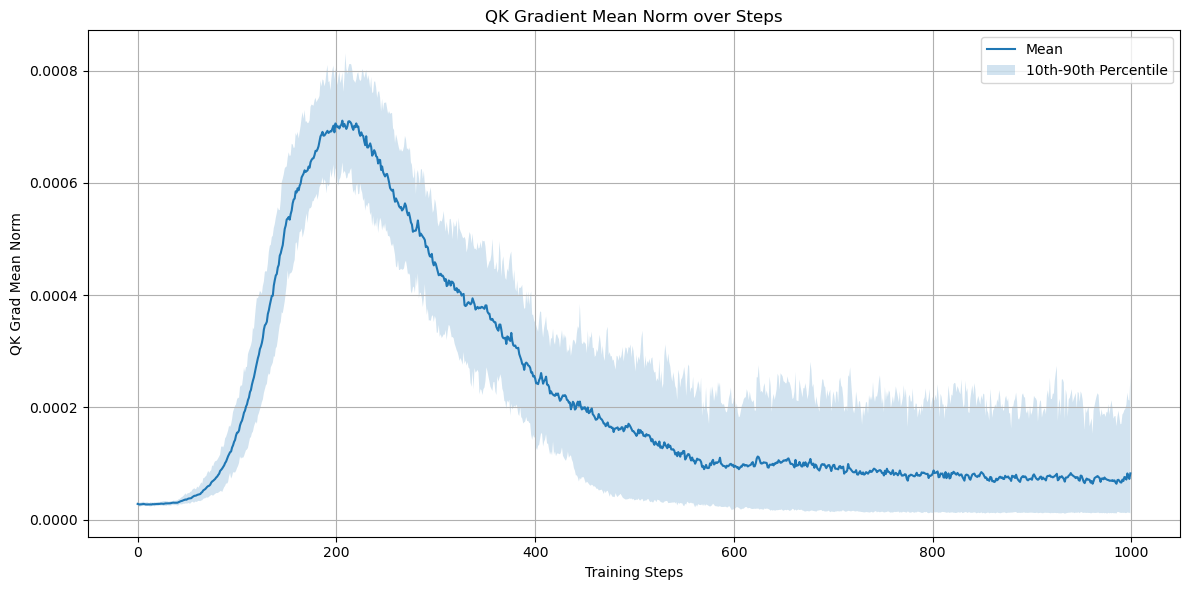

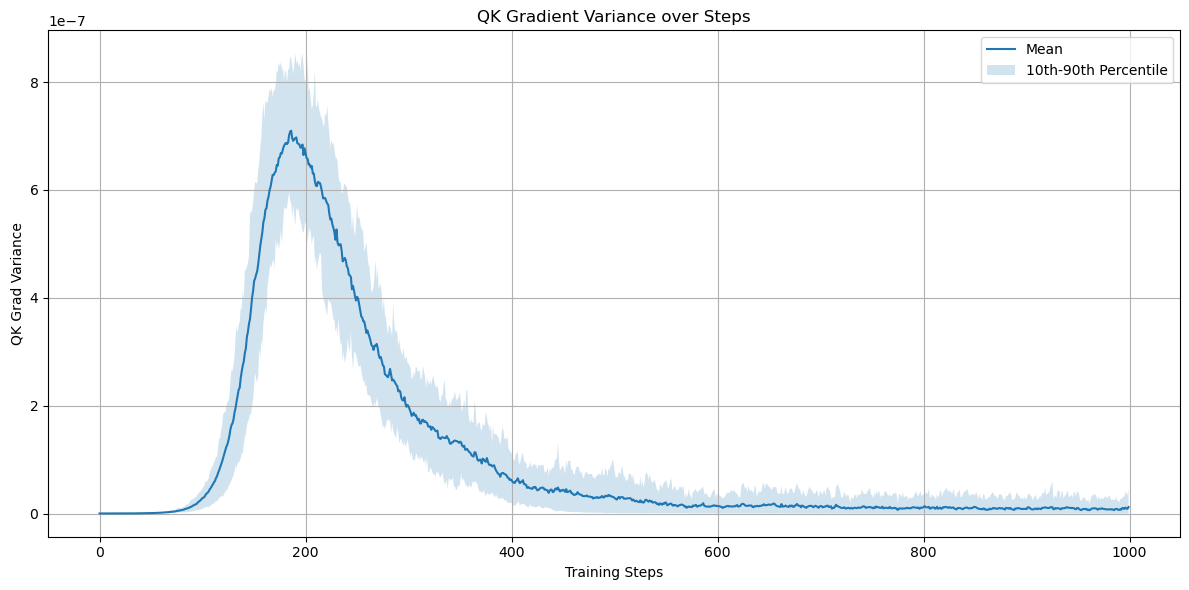

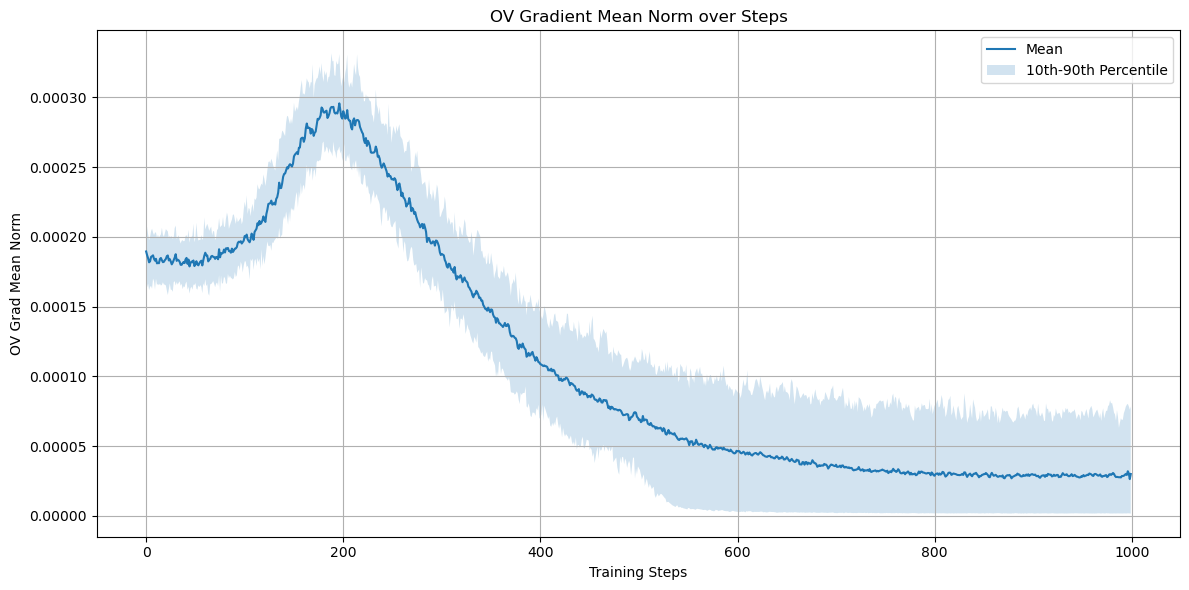

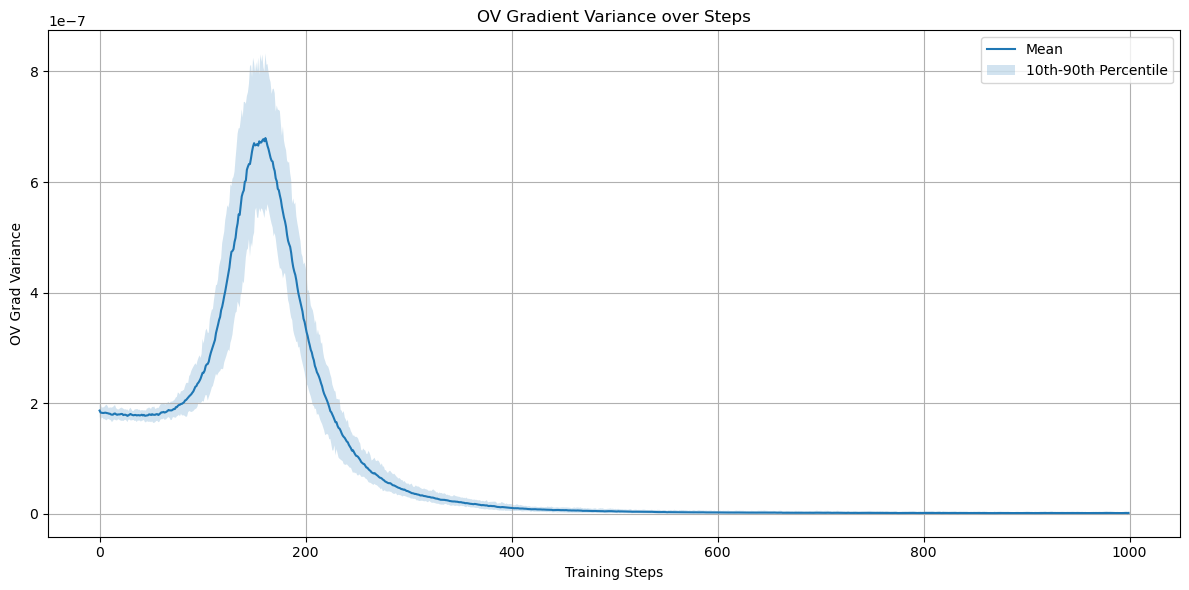

In [1]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Authenticate with WandB
wandb.login()

# Initialize the WandB API
api = wandb.Api()

# Specify the project and entity
entity = 'physicsofintelligence'  # Replace with your WandB username or team name
project = 'indexing-test'         # Replace with your WandB project name

# Fetch all runs in the project
runs = api.runs(f"{entity}/{project}")

# Filter runs with names starting with 'seed_'
seed_runs = [run for run in runs if run.name.startswith('seed_')]

# Ensure we have runs to process
if not seed_runs:
    print("No runs found with names starting with 'seed_{n}'.")
    exit()

# Prepare lists to store the gradient statistics
steps_list = []
qk_grad_mean_norm_list = []
qk_grad_variance_list = []
ov_grad_mean_norm_list = []
ov_grad_variance_list = []

# Fetch metrics from each run
for run in seed_runs:
    # Get the history of the run
    history = run.history(keys=[
        '_step',
        'grad/qk_grad_mean',
        'grad/qk_grad_var',
        'grad/ov_grad_mean',
        'grad/ov_grad_var'
    ], pandas=True)

    if history.empty:
        print(f"Run {run.name} has no gradient data.")
        continue

    # Append to lists
    steps_list.append(history['_step'].values)
    qk_grad_mean_norm_list.append(history['grad/qk_grad_mean'].values)
    qk_grad_variance_list.append(history['grad/qk_grad_var'].values)
    ov_grad_mean_norm_list.append(history['grad/ov_grad_mean'].values)
    ov_grad_variance_list.append(history['grad/ov_grad_var'].values)

# Ensure all arrays are aligned by interpolating to a common step sequence
common_steps = np.unique(np.concatenate(steps_list))

def interpolate_runs(steps_list, metric_list):
    metric_interp = []
    for steps, metrics in zip(steps_list, metric_list):
        # Handle runs that might have NaN or missing values
        valid_indices = ~np.isnan(steps) & ~np.isnan(metrics)
        steps = steps[valid_indices]
        metrics = metrics[valid_indices]
        interp_metrics = np.interp(common_steps, steps, metrics, left=np.nan, right=np.nan)
        metric_interp.append(interp_metrics)
    return metric_interp

qk_grad_mean_norm_interp = interpolate_runs(steps_list, qk_grad_mean_norm_list)
qk_grad_variance_interp = interpolate_runs(steps_list, qk_grad_variance_list)
ov_grad_mean_norm_interp = interpolate_runs(steps_list, ov_grad_mean_norm_list)
ov_grad_variance_interp = interpolate_runs(steps_list, ov_grad_variance_list)

# Convert lists to NumPy arrays
qk_grad_mean_norm_array = np.array(qk_grad_mean_norm_interp)
qk_grad_variance_array = np.array(qk_grad_variance_interp)
ov_grad_mean_norm_array = np.array(ov_grad_mean_norm_interp)
ov_grad_variance_array = np.array(ov_grad_variance_interp)

# Compute mean and percentiles
def compute_stats(array):
    mean = np.nanmean(array, axis=0)
    var = np.nanvar(array, axis=0)
    percentile_10 = np.nanpercentile(array, 10, axis=0)
    percentile_90 = np.nanpercentile(array, 90, axis=0)
    return mean, var, percentile_10, percentile_90

qk_grad_mean_norm_stats = compute_stats(qk_grad_mean_norm_array)
qk_grad_variance_stats = compute_stats(qk_grad_variance_array)
ov_grad_mean_norm_stats = compute_stats(ov_grad_mean_norm_array)
ov_grad_variance_stats = compute_stats(ov_grad_variance_array)

# Plotting function
def plot_stats(common_steps, stats, title, ylabel):
    mean, var, p10, p90 = stats
    plt.figure(figsize=(12, 6))
    plt.plot(common_steps, mean, label='Mean')
    plt.fill_between(common_steps, p10, p90, alpha=0.2, label='10th-90th Percentile')
    plt.xlabel('Training Steps')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot QK Gradient Mean Norm
plot_stats(common_steps, qk_grad_mean_norm_stats, 'QK Gradient Mean Norm over Steps', 'QK Grad Mean Norm')

# Plot QK Gradient Variance
plot_stats(common_steps, qk_grad_variance_stats, 'QK Gradient Variance over Steps', 'QK Grad Variance')

# Plot OV Gradient Mean Norm
plot_stats(common_steps, ov_grad_mean_norm_stats, 'OV Gradient Mean Norm over Steps', 'OV Grad Mean Norm')

# Plot OV Gradient Variance
plot_stats(common_steps, ov_grad_variance_stats, 'OV Gradient Variance over Steps', 'OV Grad Variance')

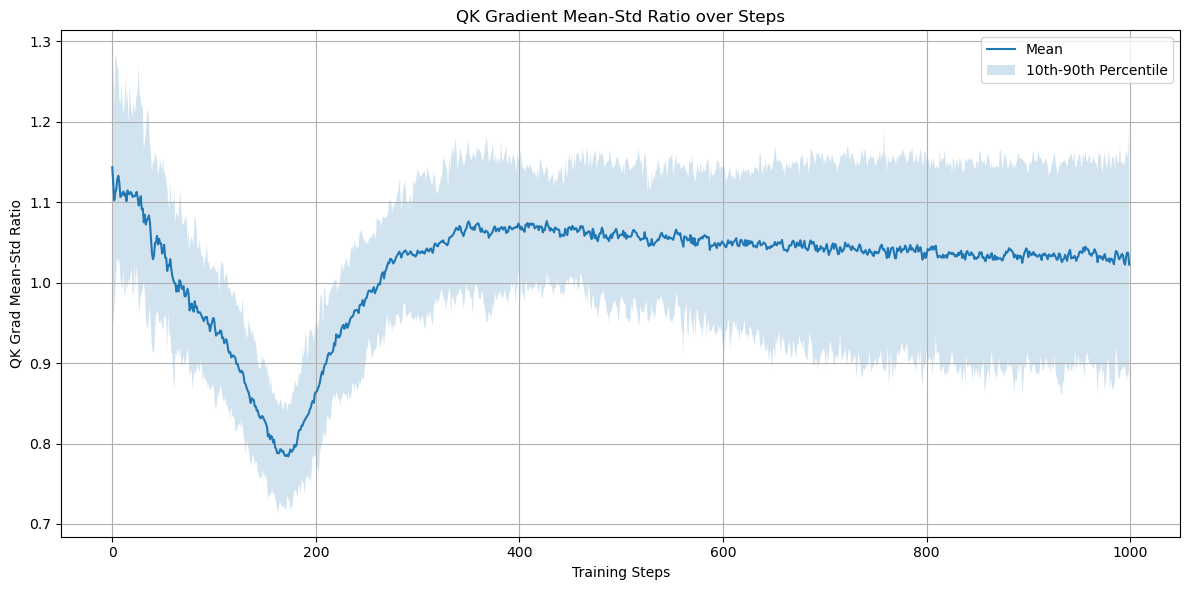

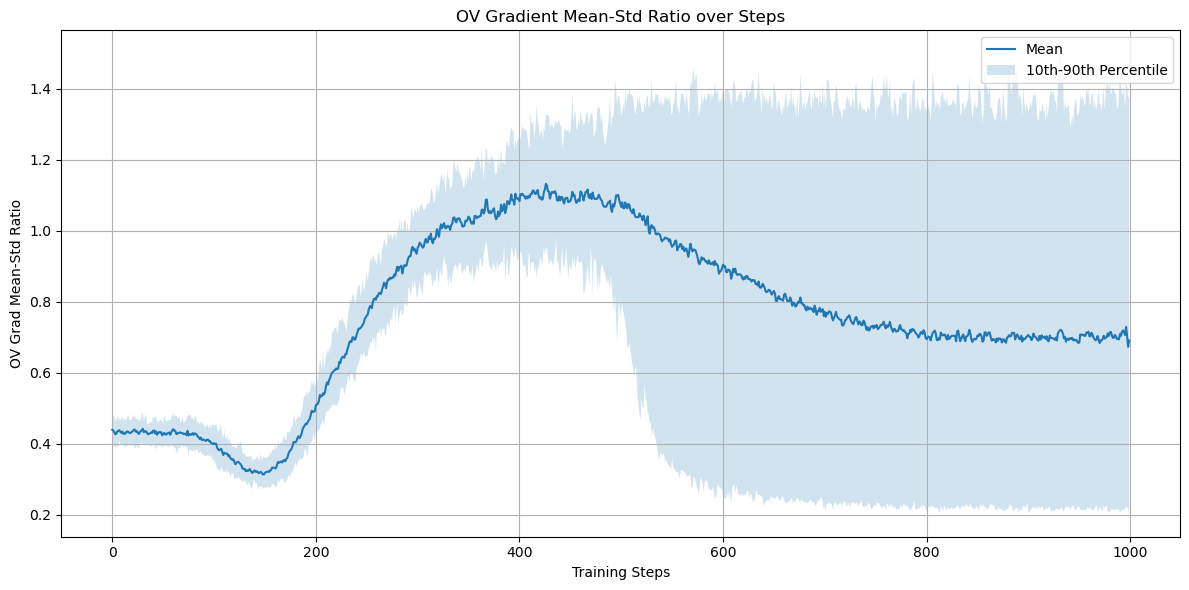

In [8]:
# ... existing code ...

# Compute mean-std ratio
def compute_mean_std_ratio(mean_array, std_array):
    return np.where(std_array != 0, mean_array / std_array, np.nan)

# Compute standard deviation arrays from variance
qk_grad_std_array = np.sqrt(qk_grad_variance_array)
ov_grad_std_array = np.sqrt(ov_grad_variance_array)

qk_mean_std_ratio = compute_mean_std_ratio(qk_grad_mean_norm_array, qk_grad_std_array)
ov_mean_std_ratio = compute_mean_std_ratio(ov_grad_mean_norm_array, ov_grad_std_array)

# Compute stats for mean-std ratios
qk_mean_std_ratio_stats = compute_stats(qk_mean_std_ratio)
ov_mean_std_ratio_stats = compute_stats(ov_mean_std_ratio)

# Plot QK Mean-Std Ratio
plot_stats(common_steps, qk_mean_std_ratio_stats, 'QK Gradient Mean-Std Ratio over Steps', 'QK Grad Mean-Std Ratio')

# Plot OV Mean-Std Ratio
plot_stats(common_steps, ov_mean_std_ratio_stats, 'OV Gradient Mean-Std Ratio over Steps', 'OV Grad Mean-Std Ratio')

# ... existing code ...

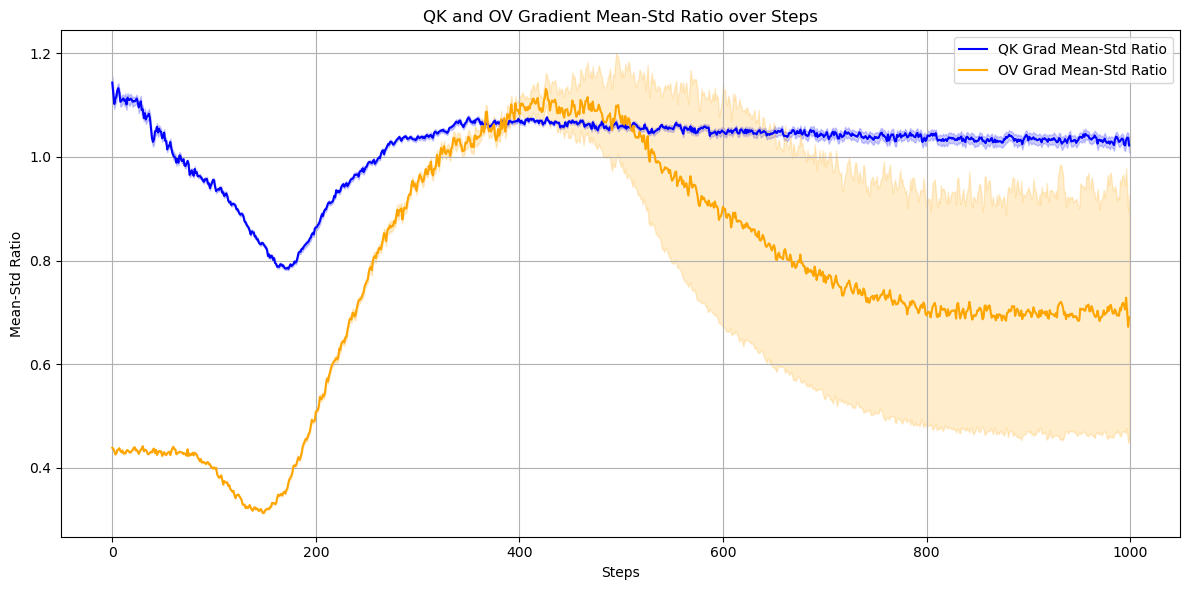

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(common_steps, qk_mean_std_ratio_stats[0], label='QK Grad Mean-Std Ratio', color='blue')
plt.fill_between(
    common_steps, 
    qk_mean_std_ratio_stats[0] - qk_mean_std_ratio_stats[1],
    qk_mean_std_ratio_stats[0] + qk_mean_std_ratio_stats[1],
    alpha=0.2, 
    color='blue'
)

plt.plot(common_steps, ov_mean_std_ratio_stats[0], label='OV Grad Mean-Std Ratio', color='orange')
plt.fill_between(
    common_steps, 
    ov_mean_std_ratio_stats[0] - ov_mean_std_ratio_stats[1],
    ov_mean_std_ratio_stats[0] + ov_mean_std_ratio_stats[1],
    alpha=0.2, 
    color='orange'
)

plt.xlabel('Steps')
plt.ylabel('Mean-Std Ratio')
plt.title('QK and OV Gradient Mean-Std Ratio over Steps')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

